### Load from database

In [1]:
from activity_tracker.pipeline import models, measurement, subject, visit

import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

df_subject = subject.Subject.fetch(format="frame").reset_index()
df_visit = visit.Visit.fetch(format="frame").reset_index()
df_measurement = measurement.DailyMeasurement.fetch(format="frame").reset_index()
df_frailty = models.Frailty.fetch(format="frame").reset_index()

[2025-08-25 15:40:41,011][INFO]: DataJoint 0.14.4 connected to root@localhost:3306


### Demographics

In [55]:
control_count = df_subject[df_subject['group'] == 'control']['subject_id'].nunique()
exercise_count = df_subject[df_subject['group'] == 'exercise']['subject_id'].nunique()

print(f"Unique patients in control group: {control_count}")
print(f"Unique patients in exercise group: {exercise_count}")
print(f"Total unique patients: {control_count + exercise_count}")

Unique patients in control group: 52
Unique patients in exercise group: 49
Total unique patients: 101


In [5]:
# Measure days per subject
measure_days_df = df_measurement.groupby('subject_id').size().reset_index(name='measured_days').sort_values(by='measured_days', ascending=False)
measure_days_df

,subject_id,measured_days
72,MDE074,316
24,MDE025,299
79,MDE081,286
41,MDE042,246
40,MDE041,246
26,MDE027,246
85,MDE087,246
87,MDE089,241
37,MDE038,240
95,MDE097,238


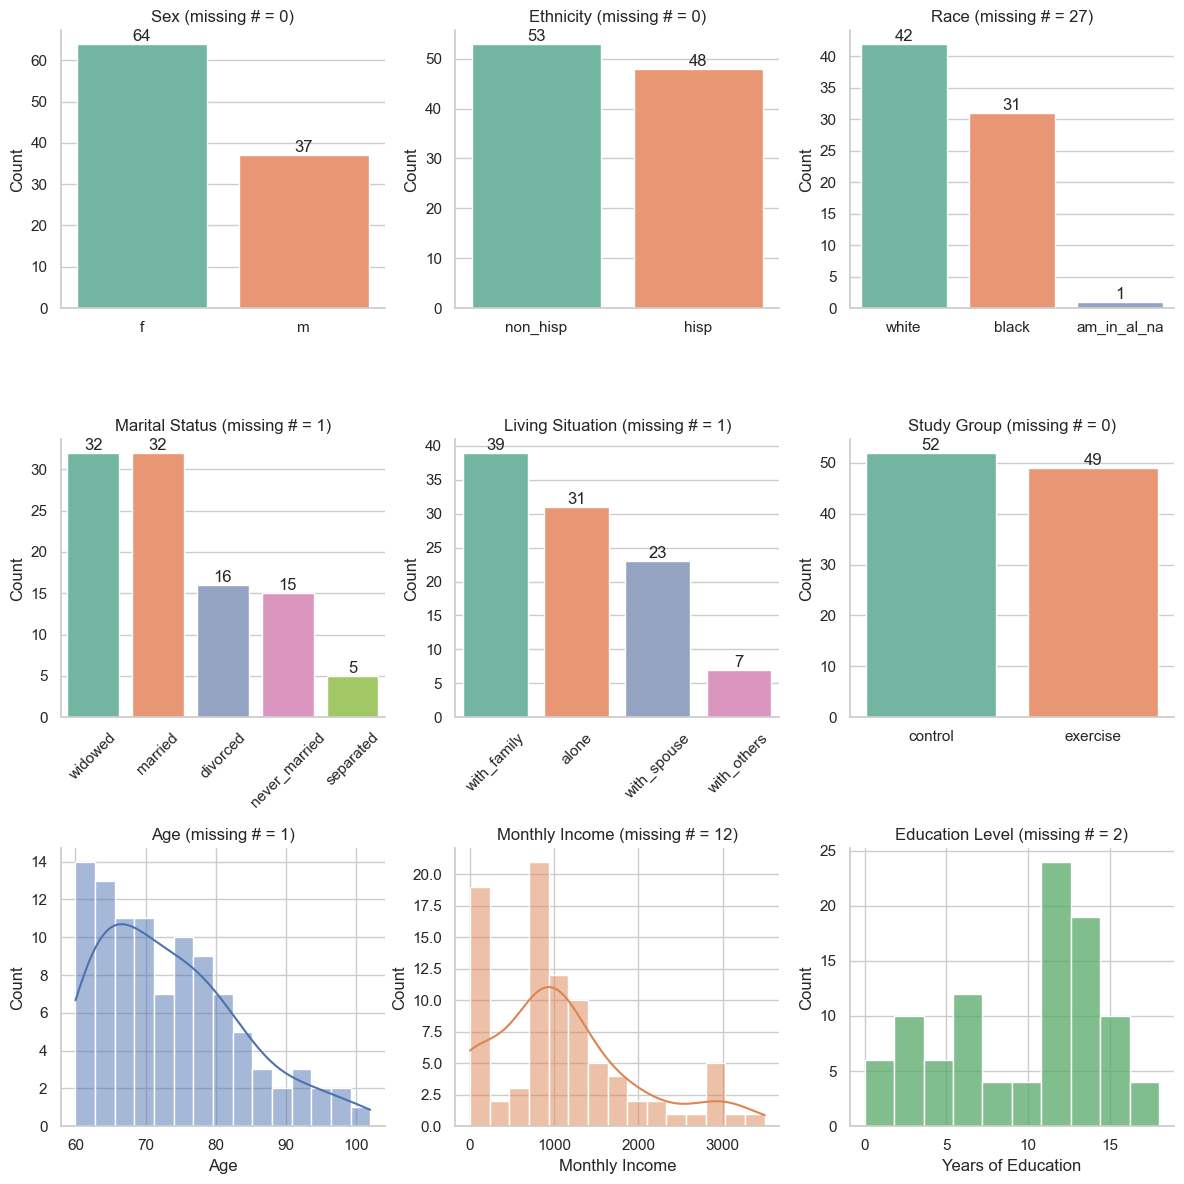

In [6]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(12, 12), dpi=100)
cat_vars = [
    ("sex", "Sex"),
    ("ethnicity", "Ethnicity"),
    ("race", "Race"),
    ("marital_status", "Marital Status"),
    ("living_situation", "Living Situation"),
    ("group", "Study Group"),
]

for idx, (col, title) in enumerate(cat_vars):
    ax = axes[idx // 3, idx % 3]
    counts = df_subject[col].value_counts()
    missing_count = df_subject[col].isna().sum()
    sns.barplot(x=counts.index, y=counts.values, ax=ax, palette="Set2")
    ax.set_title(f"{title} (missing # = {missing_count})")
    ax.set_ylabel("Count")
    ax.set_xlabel("")
    if col in ["marital_status", "living_situation"]:
        ax.tick_params(axis='x', rotation=45)
    else:
        ax.tick_params(axis='x', rotation=0)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom')
    sns.despine(ax=ax)

# Age
age_missing = df_subject["age"].isna().sum()
sns.histplot(df_subject["age"].dropna(), bins=15, kde=True, ax=axes[2, 0], color="#4c72b0")
axes[2, 0].set_title(f"Age (missing # = {age_missing})")
axes[2, 0].set_xlabel("Age")
sns.despine(ax=axes[2, 0])

# Monthly income
income_missing = df_subject["monthly_income"].isna().sum()
sns.histplot(df_subject["monthly_income"].dropna(), bins=15, kde=True, ax=axes[2, 1], color="#dd8452")
axes[2, 1].set_title(f"Monthly Income (missing # = {income_missing})")
axes[2, 1].set_xlabel("Monthly Income")
sns.despine(ax=axes[2, 1])

# Education
education_missing = df_subject["education"].isna().sum()
sns.histplot(df_subject["education"].dropna(), bins=10, kde=False, ax=axes[2, 2], color="#55a868")
axes[2, 2].set_title(f"Education Level (missing # = {education_missing})")
axes[2, 2].set_xlabel("Years of Education")
sns.despine(ax=axes[2, 2])

plt.tight_layout()
plt.show()

### Visit analysis

In [7]:
plt.figure(figsize=(30, 25), dpi=300)
sns.scatterplot(
    data=df_measurement,
    x='date',
    y='subject_id',
    s=13,
    alpha=0.7,
    label='Measurement'
)
plt.xlabel('Date')
plt.ylabel('Subject ID')
plt.title('Measurement Days')

subjects = sorted(df_measurement['subject_id'].unique())
plt.ylim(subjects[-1], subjects[0])
plt.gca().set_ylim(plt.gca().get_ylim()[0] + 1, plt.gca().get_ylim()[1] - 1)

# Mark visit dates
plt.scatter(
    df_visit['date'],
    df_visit['subject_id'],
    color='red',
    marker='*',
    s=50,
    label='Visit Date'
)

plt.legend()
plt.tight_layout()
plt.show()

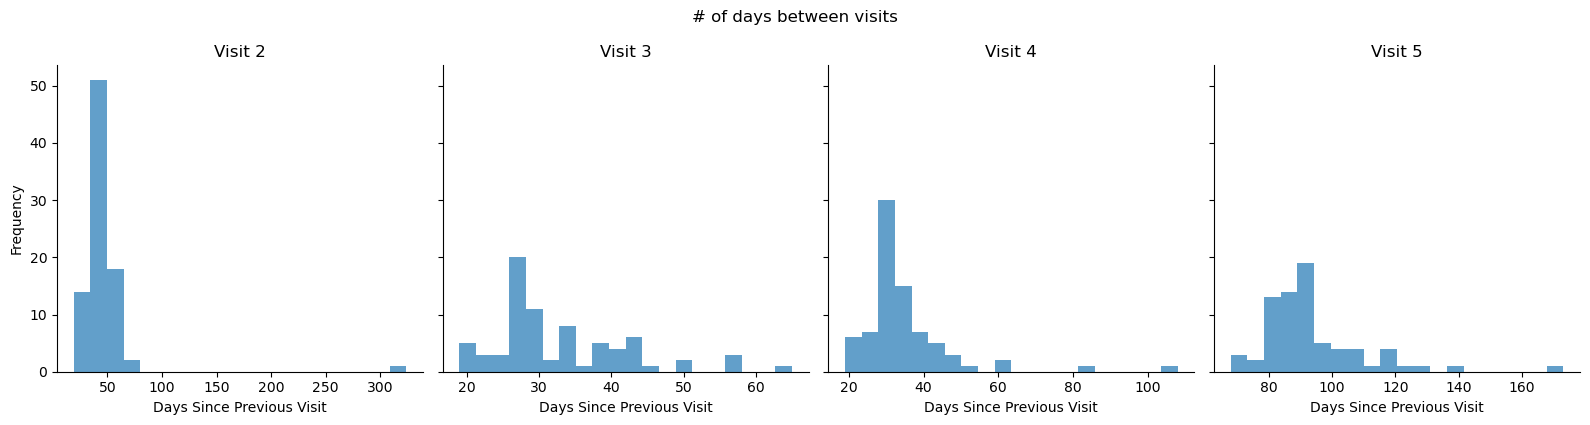

In [11]:
# Visit intervals

# Add prev visit date and ffp status binary
df_merged = df_frailty.merge(df_visit, on=('subject_id', 'visit_id'), how='left')

df_merged.sort_values(["subject_id", "visit_id"])
df_merged["prev_visit_date"] = df_merged.groupby("subject_id")["date"].shift(1)
df_merged["prev_ffp_status"] = df_merged.groupby("subject_id")["ffp_status"].shift(1)
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged['days_since_prev_visit'] = df_merged.groupby('subject_id')['date'].diff().dt.days

visit_ids = sorted([v for v in df_merged['visit_id'].unique() if v != 1])
n_visits = len(visit_ids)

fig, axes = plt.subplots(1, n_visits, figsize=(4 * n_visits, 4), sharey=True)

for i, visit_id in enumerate(visit_ids):
    ax = axes[i]
    group = df_merged[df_merged['visit_id'] == visit_id]
    ax.hist(group['days_since_prev_visit'].dropna(), bins=20, alpha=0.7)
    ax.set_title(f'Visit {visit_id}')
    ax.set_xlabel('Days Since Previous Visit')
    sns.despine(ax=ax)
    if i == 0:
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('# of days between visits', y=1.05)
plt.show()

In [15]:
df_merged[df_merged['subject_id'] == "MDE088"]

,subject_id,visit_id,wt_loss,weak,slow,exhaust,phys_act,ffp_score,ffp_status,ffp_status_binary,date,prev_visit_date,prev_ffp_status,days_since_prev_visit
359,MDE088,1,0,1,0,0,0,1,prefrail,no_frail,2023-01-30,NaN,NaN,NaN
360,MDE088,2,0,1,0,0,0,1,prefrail,no_frail,2023-12-20,2023-01-30,prefrail,324.0
361,MDE088,3,None,None,None,None,None,None,None,None,2024-01-29,2023-12-20,prefrail,40.0


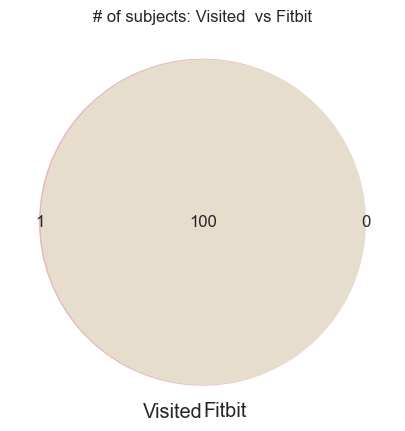

{'MDE043'} was visited but not no fitbit measurement data


In [8]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

visited_subjects = set(df_visit["subject_id"].unique())
measured_subjects = set(df_measurement["subject_id"].unique())
both_subjects = visited_subjects & measured_subjects

# venn diagram
plt.figure(figsize=(5, 5))
venn2([visited_subjects, measured_subjects], set_labels=('Visited', 'Fitbit'))
plt.title('# of subjects: Visited  vs Fitbit')
plt.show()

len(df_measurement["subject_id"].unique()) # number of subjects with fitbit measurements
len(df_visit["subject_id"].unique()) # number of subjects with visits

print(f"{visited_subjects - measured_subjects} was visited but not no fitbit measurement data")

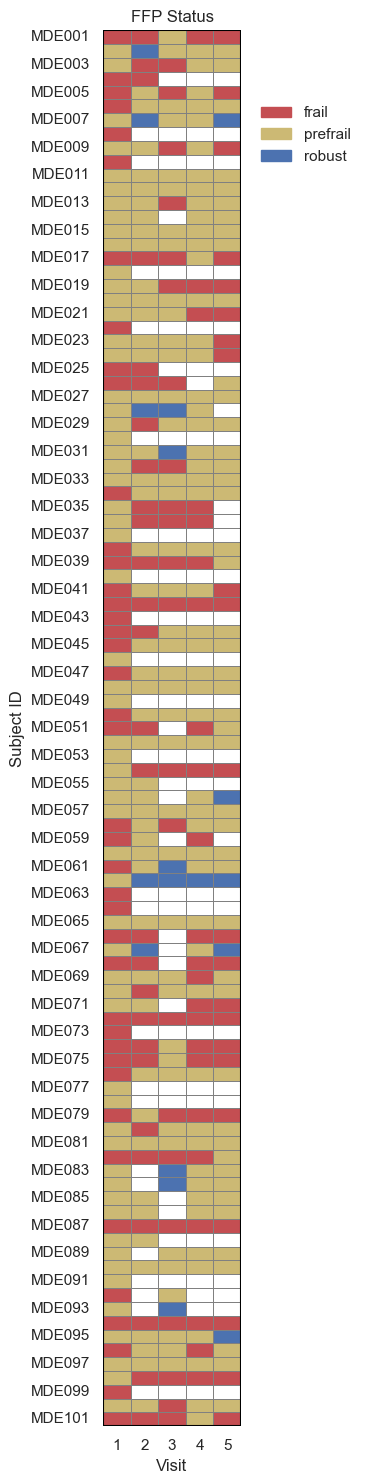

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from activity_tracker import utils

# Load mapping
mapping_dict = utils.load_data_mapper("../data/data_mapper.yml")
ffp_labels = mapping_dict['ffp_status']

# Create mapping from string values to numeric for heatmap
status_mapping = {'frail': 0, 'prefrail': 1, 'robust': 2}
df_frailty['ffp_status_numeric'] = df_frailty['ffp_status'].map(status_mapping)

colors = ['r', 'y', 'b']  # frail, prefrail, robust
cmap = ListedColormap(colors)
cmap.set_bad('white')  
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

# Create heatmap matrix using numeric values
heat_matrix = df_frailty.pivot(index='subject_id', columns='visit_id', values='ffp_status_numeric')
heat_matrix = heat_matrix.reindex(sorted(heat_matrix.columns), axis=1)

# Plot
plt.figure(figsize=(4, 15))
ax = sns.heatmap(
    heat_matrix,
    cmap=cmap,
    norm=norm,
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    square=False,
    mask=heat_matrix.isna()
)

# Add a rectangle boundary around the heatmap
ax.add_patch(
    patches.Rectangle(
        (0, 0),
        heat_matrix.shape[1],
        heat_matrix.shape[0],
        fill=False,
        edgecolor='black',
        lw=1.5
    )
)

# Custom legend with dots
legend_labels = [mpatches.Patch(color=colors[i], label=ffp_labels[i]) for i in range(3)]
plt.legend(
    handles=legend_labels,
    bbox_to_anchor=(1.1, 0.95),
    loc='upper left',
    borderaxespad=0.,
    frameon=False
)

plt.title('FFP Status')
plt.xlabel('Visit')
plt.ylabel('Subject ID')
plt.tight_layout()
plt.show()

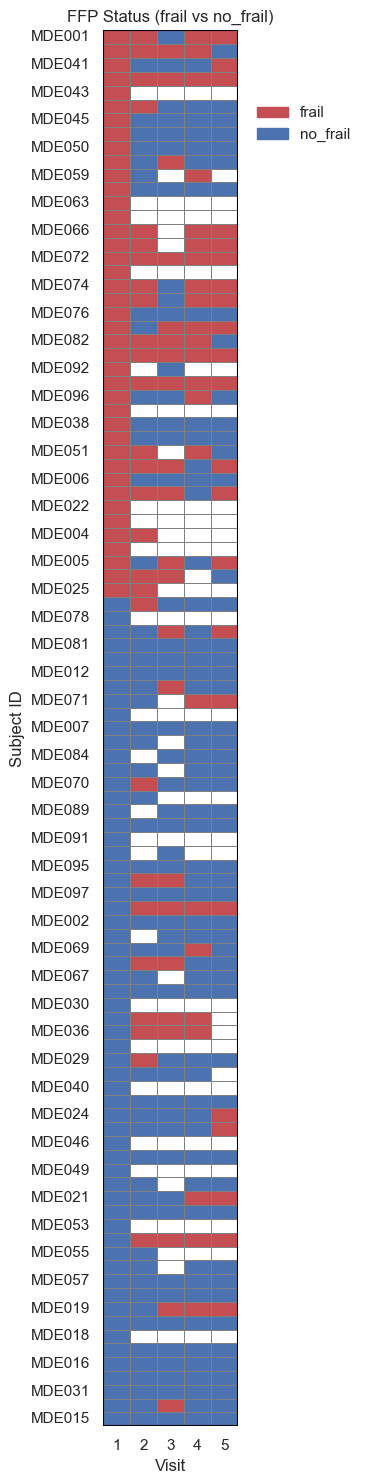

In [35]:
# Combine prefrail and robust into no_frail
heat_matrix_no_frail = heat_matrix.replace({1.0: 1, 2.0: 1})
heat_matrix_no_frail = heat_matrix_no_frail.sort_values(by=1)
# For plotting
colors = ['r', 'b']  # frail, no_frail
labels = ['frail', 'no_frail']
cmap = ListedColormap(colors)
cmap.set_bad('white')
bounds = [-0.5, 0.5, 1.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(4, 15))
ax = sns.heatmap(
    heat_matrix_no_frail,
    cmap=cmap,
    norm=norm,
    linewidths=0.5,
    linecolor='gray',
    cbar=False,
    square=False,
    mask=heat_matrix_no_frail.isna()
)
# Add a rectangle boundary around the heatmap
ax.add_patch(
    patches.Rectangle(
        (0, 0),
        heat_matrix.shape[1],
        heat_matrix.shape[0],
        fill=False,
        edgecolor='black',
        lw=1.5
    )
)

# Custom legend
legend_labels = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(2)]
plt.legend(
    handles=legend_labels,
    bbox_to_anchor=(1.1, 0.95),
    loc='upper left',
    borderaxespad=0.,
    frameon=False
)

plt.title('FFP Status (frail vs no_frail)')
plt.xlabel('Visit')
plt.ylabel('Subject ID')
plt.tight_layout()
plt.show()

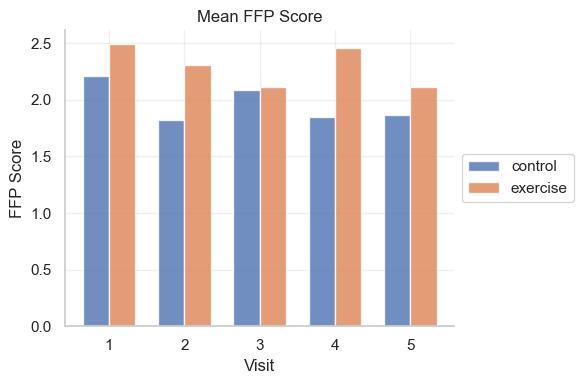

In [64]:
import numpy as np

df = df_frailty.merge(df_subject, on='subject_id', how='left')

# Calculate means for ffp_score only
mean_score = df.groupby(['group', 'visit_id'])['ffp_score'].mean().unstack('group').reset_index()

visit_ids = sorted(df['visit_id'].unique(), key=lambda x: int(x))
groups = ['control', 'exercise']
bar_width = 0.35
x = np.arange(len(visit_ids))

fig, ax = plt.subplots(figsize=(6, 4))

for i, group in enumerate(groups):
    ax.bar(x + i*bar_width, mean_score[group], bar_width, label=group, alpha=0.8)

ax.set_title('Mean FFP Score')
ax.set_xlabel('Visit')
ax.set_ylabel('FFP Score')
ax.set_xticks(x + bar_width/2)
ax.set_xticklabels(visit_ids)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True, alpha=0.3)

plt.tight_layout()
sns.despine()
plt.show()

In [65]:
import plotly.graph_objects as go

# Plot using Plotly
ffp_distribution = df.groupby(["visit_id", "ffp_status"]).size().unstack(fill_value=0)

fig = go.Figure()
statuses = df['ffp_status'].unique()
labels = statuses
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for status, label, color in zip(statuses, labels, colors):
    fig.add_trace(go.Bar(
        x=ffp_distribution.index.astype(str),
        y=ffp_distribution[status],
        name=label,
        text=ffp_distribution[status],
        textposition='inside',
        marker_color=color
    ))

fig.update_layout(
    width=800,  
    height=500, 
    title="FFP Status",
    xaxis_title="Visit",
    yaxis_title="Number of Participants",
    barmode='stack',
    legend_title="FFP Status"
)

fig.show()

### State transition

In [46]:
# Sankey plot of frailty status transitions across visits
import pandas as pd
import plotly.graph_objects as go

# Prepare your data
df_wide = df_frailty.pivot(index='subject_id', columns='visit_id', values='ffp_status_binary')
df_wide = df_wide.sort_index(axis=1) 

labels = ['frail', 'no_frail']
short_labels = {'frail': 'F', 'no_frail': 'N'}

# Node labels: just short label (count)
node_labels = []
for v in range(1, df_wide.shape[1]+1):
    for label in labels:
        count = (df_wide[v] == label).sum()
        node_labels.append(f"{short_labels[label]} ({count})")

sources = []
targets = []
values = []
custom_labels = []

for v in range(1, df_wide.shape[1]): 
    from_states = df_wide[v]
    to_states = df_wide[v+1]
    ct = pd.crosstab(from_states, to_states)
    for i, from_label in enumerate(labels):
        for j, to_label in enumerate(labels):
            count = ct.get(to_label, {}).get(from_label, 0)
            if count > 0:
                sources.append(i + (v-1)*len(labels))
                targets.append(j + v*len(labels))
                values.append(count)
                custom_labels.append(f"{short_labels[from_label]}→{short_labels[to_label]}: {count}")

# Two colors: red for frail, blue for no_frail
color_map = {'frail': 'crimson', 'no_frail': 'royalblue'}
node_colors = []
for v in range(df_wide.shape[1]):
    node_colors.extend([color_map[label] for label in labels])

fig = go.Figure(data=[go.Sankey(
    node=dict(label=node_labels, color=node_colors, pad=40, thickness=40),
    link=dict(source=sources, target=targets, value=values, label=custom_labels)
)])

n_visits = df_wide.shape[1]
for v in range(n_visits):
    x = v / (n_visits - 1) if n_visits > 1 else 0.5
    fig.add_annotation(
        x=x,
        y=-0.15,
        text=f"Visit {v+1}",
        showarrow=False,
        font=dict(size=15),
        xref="paper",
        yref="paper"
    )

fig.show()

In [48]:
# Assuming df_frailty is already loaded and has 'subject_id', 'visit_id', 'ffp_status_binary'
df = df_frailty[['subject_id', 'visit_id', 'ffp_status_binary']].dropna(subset=['ffp_status_binary'])
df = df.sort_values(['subject_id', 'visit_id'])

transitions = {
    ('frail', 'frail'): 0,
    ('frail', 'no_frail'): 0,
    ('no_frail', 'frail'): 0,
    ('no_frail', 'no_frail'): 0
}

for subject, group in df.groupby('subject_id'):
    states = group['ffp_status_binary'].tolist()
    for i in range(len(states) - 1):
        if pd.notna(states[i]) and pd.notna(states[i+1]):
            transitions[(states[i], states[i+1])] += 1

transition_matrix = pd.DataFrame(
    [[transitions[('frail', 'frail')], transitions[('frail', 'no_frail')]],
     [transitions[('no_frail', 'frail')], transitions[('no_frail', 'no_frail')]]],
    index=['frail', 'no_frail'],
    columns=['frail', 'no_frail']
)
print(transition_matrix)

          frail  no_frail
frail        63        37
no_frail     31       165


In [49]:
import numpy as np
prob_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
print(prob_matrix)

eigvals, eigvecs = np.linalg.eig(prob_matrix.T)
stationary = np.real(eigvecs[:, np.isclose(eigvals, 1)])
stationary = stationary / stationary.sum()
print("Stationary distribution:", stationary.flatten())

             frail  no_frail
frail     0.630000  0.370000
no_frail  0.158163  0.841837
Stationary distribution: [0.29945904 0.70054096]


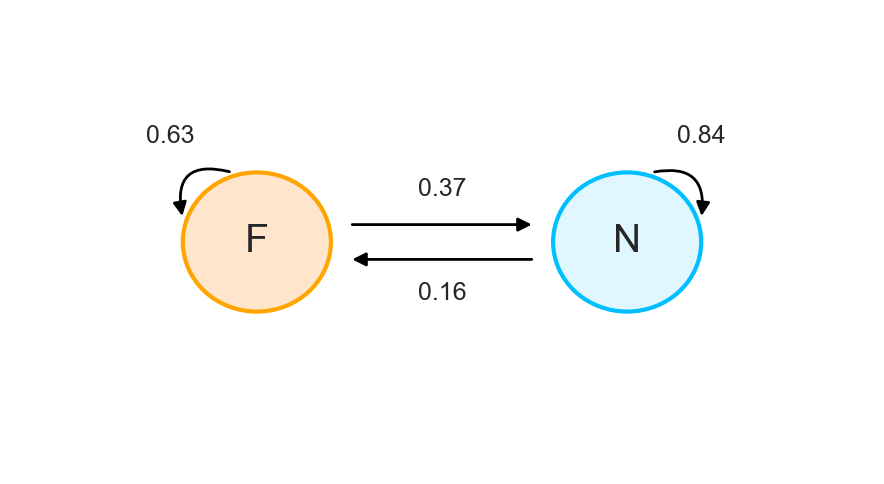

In [50]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, FancyArrowPatch

# Transition probabilities
probs = {
    ('F', 'F'): 0.630,
    ('F', 'N'): 0.370,
    ('N', 'F'): 0.158,
    ('N', 'N'): 0.842
}

# Node positions
node_pos = {'F': (0, 0), 'N': (3, 0)}

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_xlim(-2, 5)
ax.set_ylim(-2, 2)
ax.axis('off')

# Draw ellipses for nodes
ellipse_F = Ellipse(xy=node_pos['F'], width=1.2, height=1.2,
                    edgecolor='orange', facecolor='#ffe5cc', lw=3)
ellipse_N = Ellipse(xy=node_pos['N'], width=1.2, height=1.2,
                    edgecolor='deepskyblue', facecolor='#e0f7ff', lw=3)
ax.add_patch(ellipse_F)
ax.add_patch(ellipse_N)

# Add node labels
ax.text(*node_pos['F'], 'F', fontsize=28, ha='center', va='center')
ax.text(*node_pos['N'], 'N', fontsize=28, ha='center', va='center')

# Arrow style
arrowprops = dict(arrowstyle='-|>', color='black', lw=2, mutation_scale=20)

# Self-loop F
arrow = FancyArrowPatch((node_pos['F'][0] - 0.2, node_pos['F'][1] + 0.6),
                        (node_pos['F'][0] - 0.6, node_pos['F'][1] + 0.2),
                        connectionstyle="arc3,rad=0.8", **arrowprops)
ax.add_patch(arrow)
ax.text(node_pos['F'][0] - 0.9, node_pos['F'][1] + 0.85,
        f"{probs[('F','F')]:.2f}", fontsize=18)

# Self-loop N
arrow = FancyArrowPatch((node_pos['N'][0] + 0.2, node_pos['N'][1] + 0.6),
                        (node_pos['N'][0] + 0.6, node_pos['N'][1] + 0.2),
                        connectionstyle="arc3,rad=-0.7", **arrowprops)
ax.add_patch(arrow)
ax.text(node_pos['N'][0] + 0.4, node_pos['N'][1] + 0.85,
        f"{probs[('N','N')]:.2f}", fontsize=18)

# F → N
arrow = FancyArrowPatch((node_pos['F'][0] + 0.75, node_pos['F'][1] + 0.15),
                        (node_pos['N'][0] - 0.75, node_pos['N'][1] + 0.15),
                        connectionstyle="arc3,rad=0.0", **arrowprops)
ax.add_patch(arrow)
ax.text(1.5, 0.4, f"{probs[('F','N')]:.2f}", fontsize=18, ha='center')

# N → F
arrow = FancyArrowPatch((node_pos['N'][0] - 0.75, node_pos['N'][1] - 0.15),
                        (node_pos['F'][0] + 0.75, node_pos['F'][1] - 0.15),
                        connectionstyle="arc3,rad=0.0", **arrowprops)
ax.add_patch(arrow)
ax.text(1.5, -0.5, f"{probs[('N','F')]:.2f}", fontsize=18, ha='center')

plt.tight_layout()
plt.show()

In [16]:
# Prepare visit dates for each subject
df_visit['date'] = pd.to_datetime(df_visit['date'])
df_measurement['date'] = pd.to_datetime(df_measurement['date'])

visit_dates = df_visit[['subject_id', 'date', 'visit_id']].copy()

# Function to compute days since last visit for each measurement
def get_days_since_last_visit(row):
    subject_visits = visit_dates[visit_dates['subject_id'] == row['subject_id']]
    past_visits = subject_visits[subject_visits['date'] <= row['date']]
    if past_visits.empty:
        return None
    last_visit_date = past_visits['date'].max()
    return (row['date'] - last_visit_date).days

df_measurement['days_since_last_visit'] = df_measurement.apply(get_days_since_last_visit, axis=1)

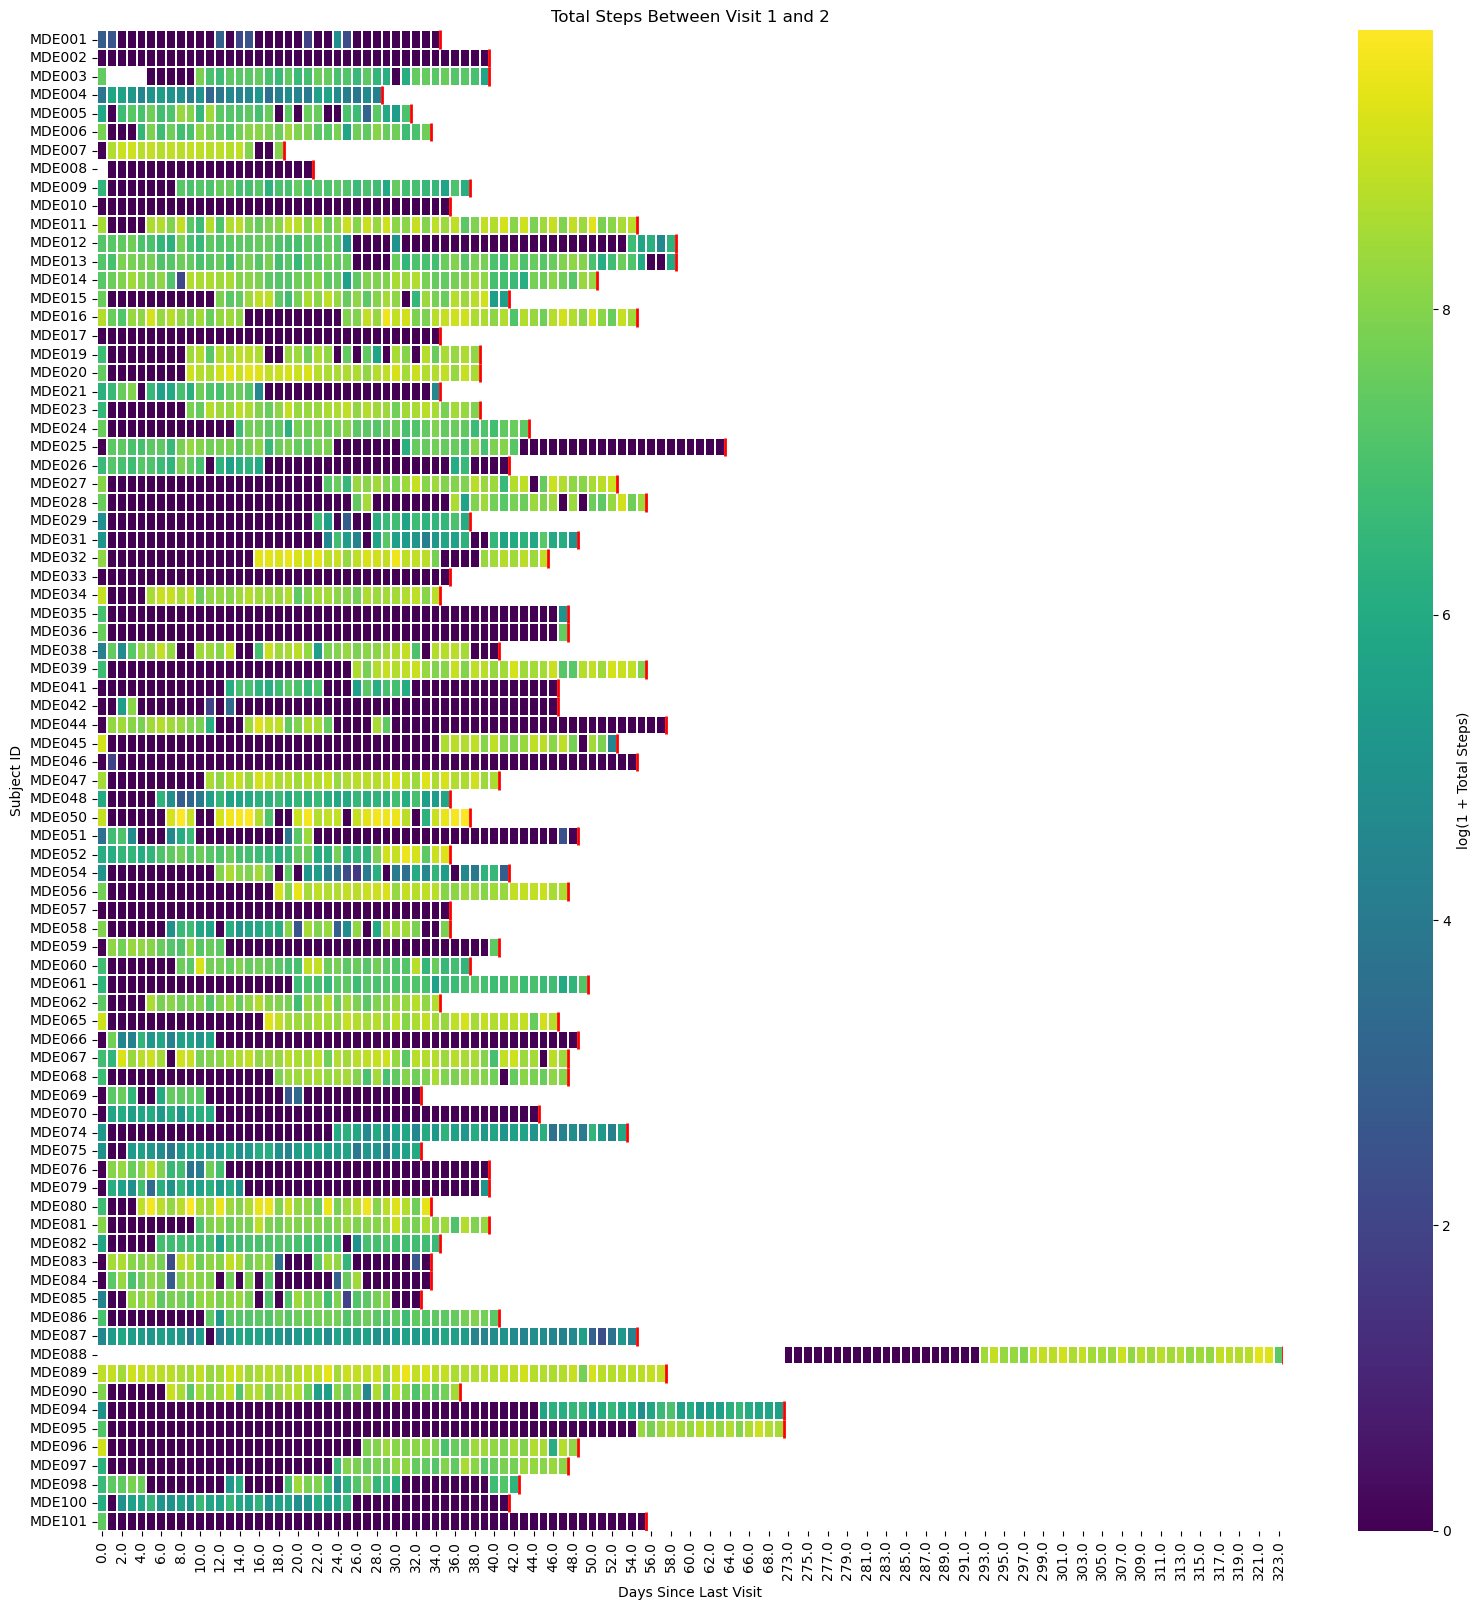

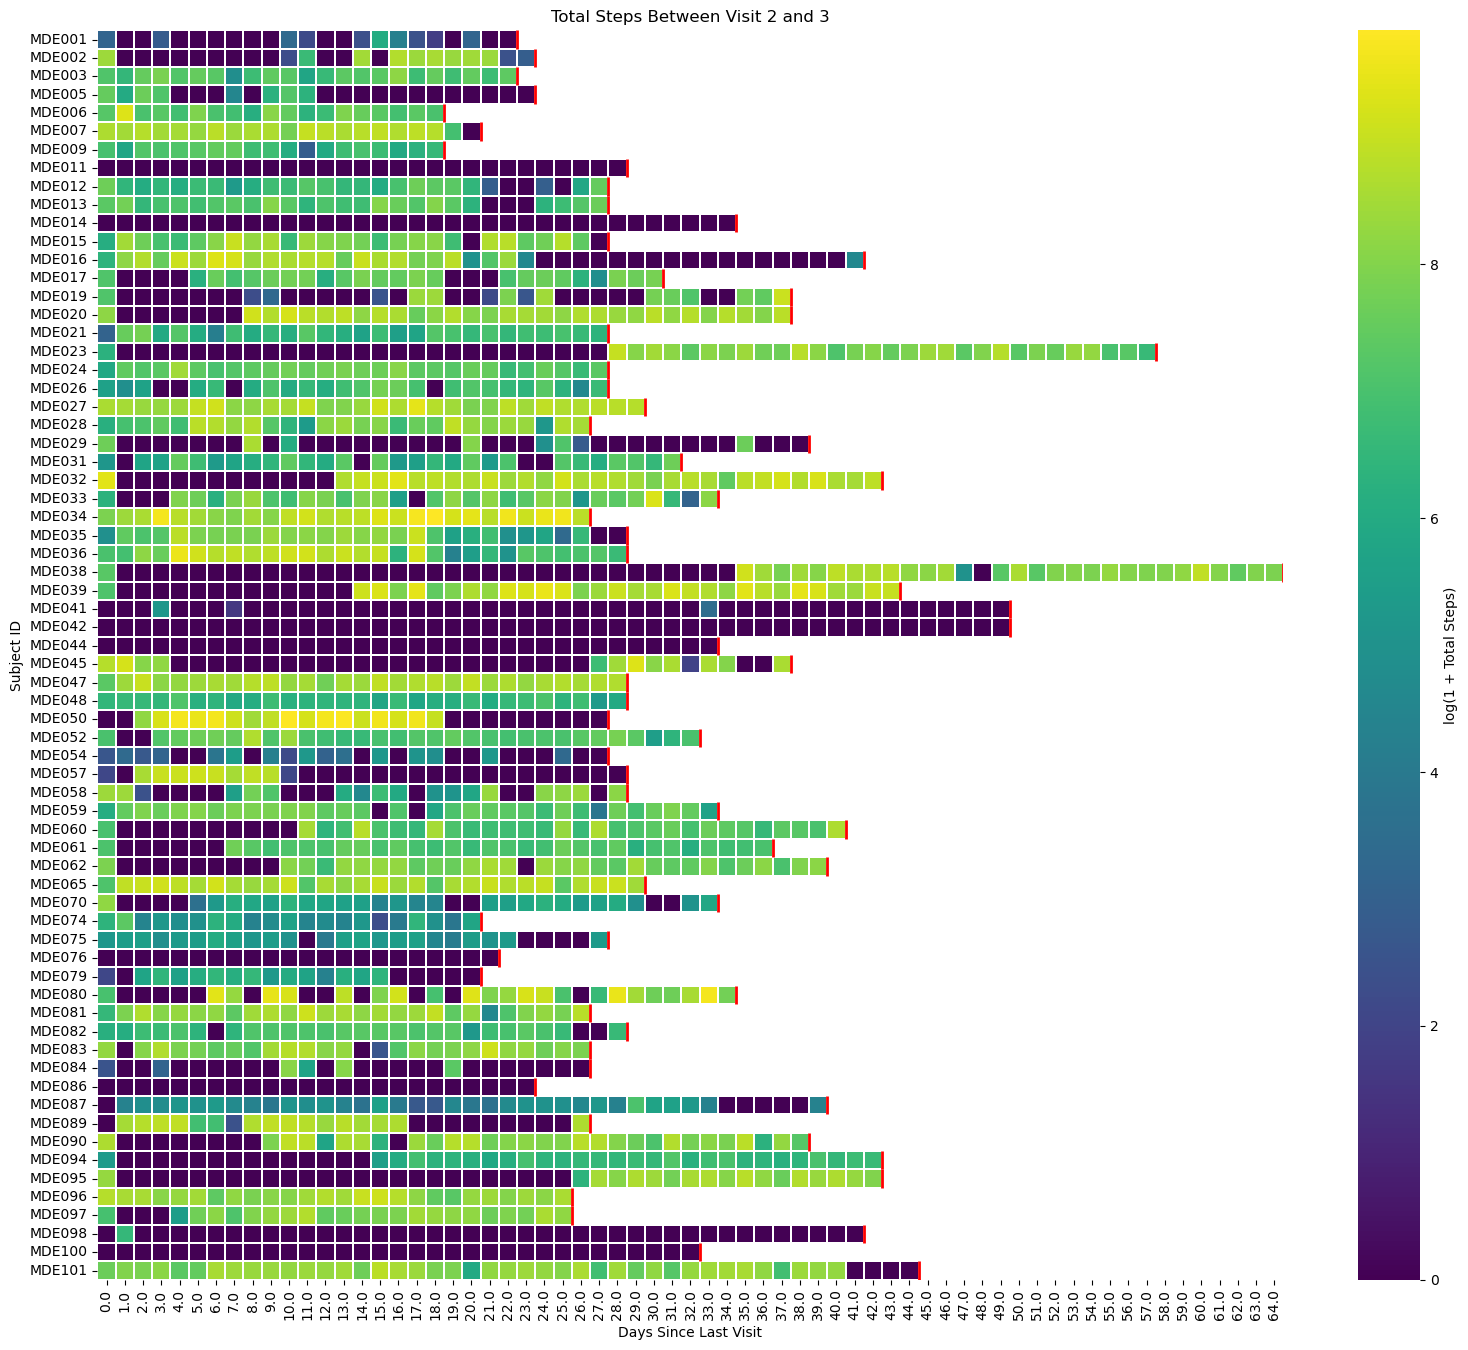

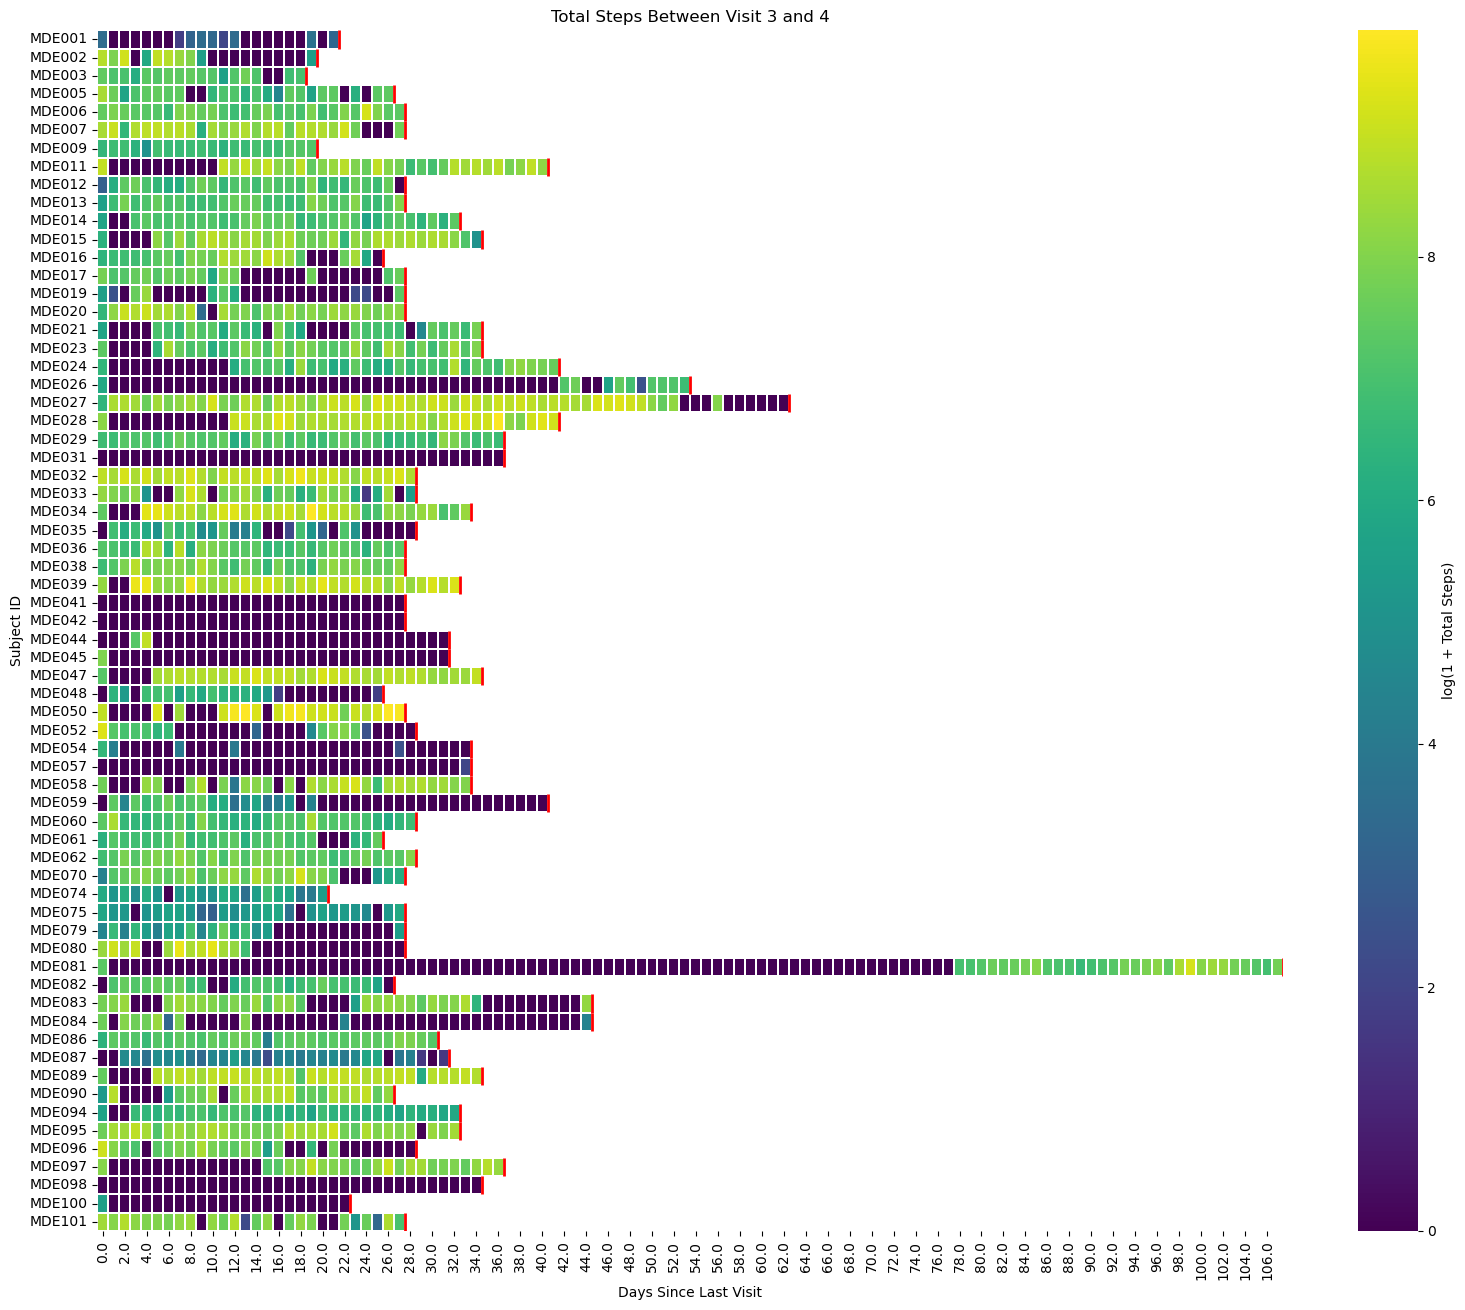

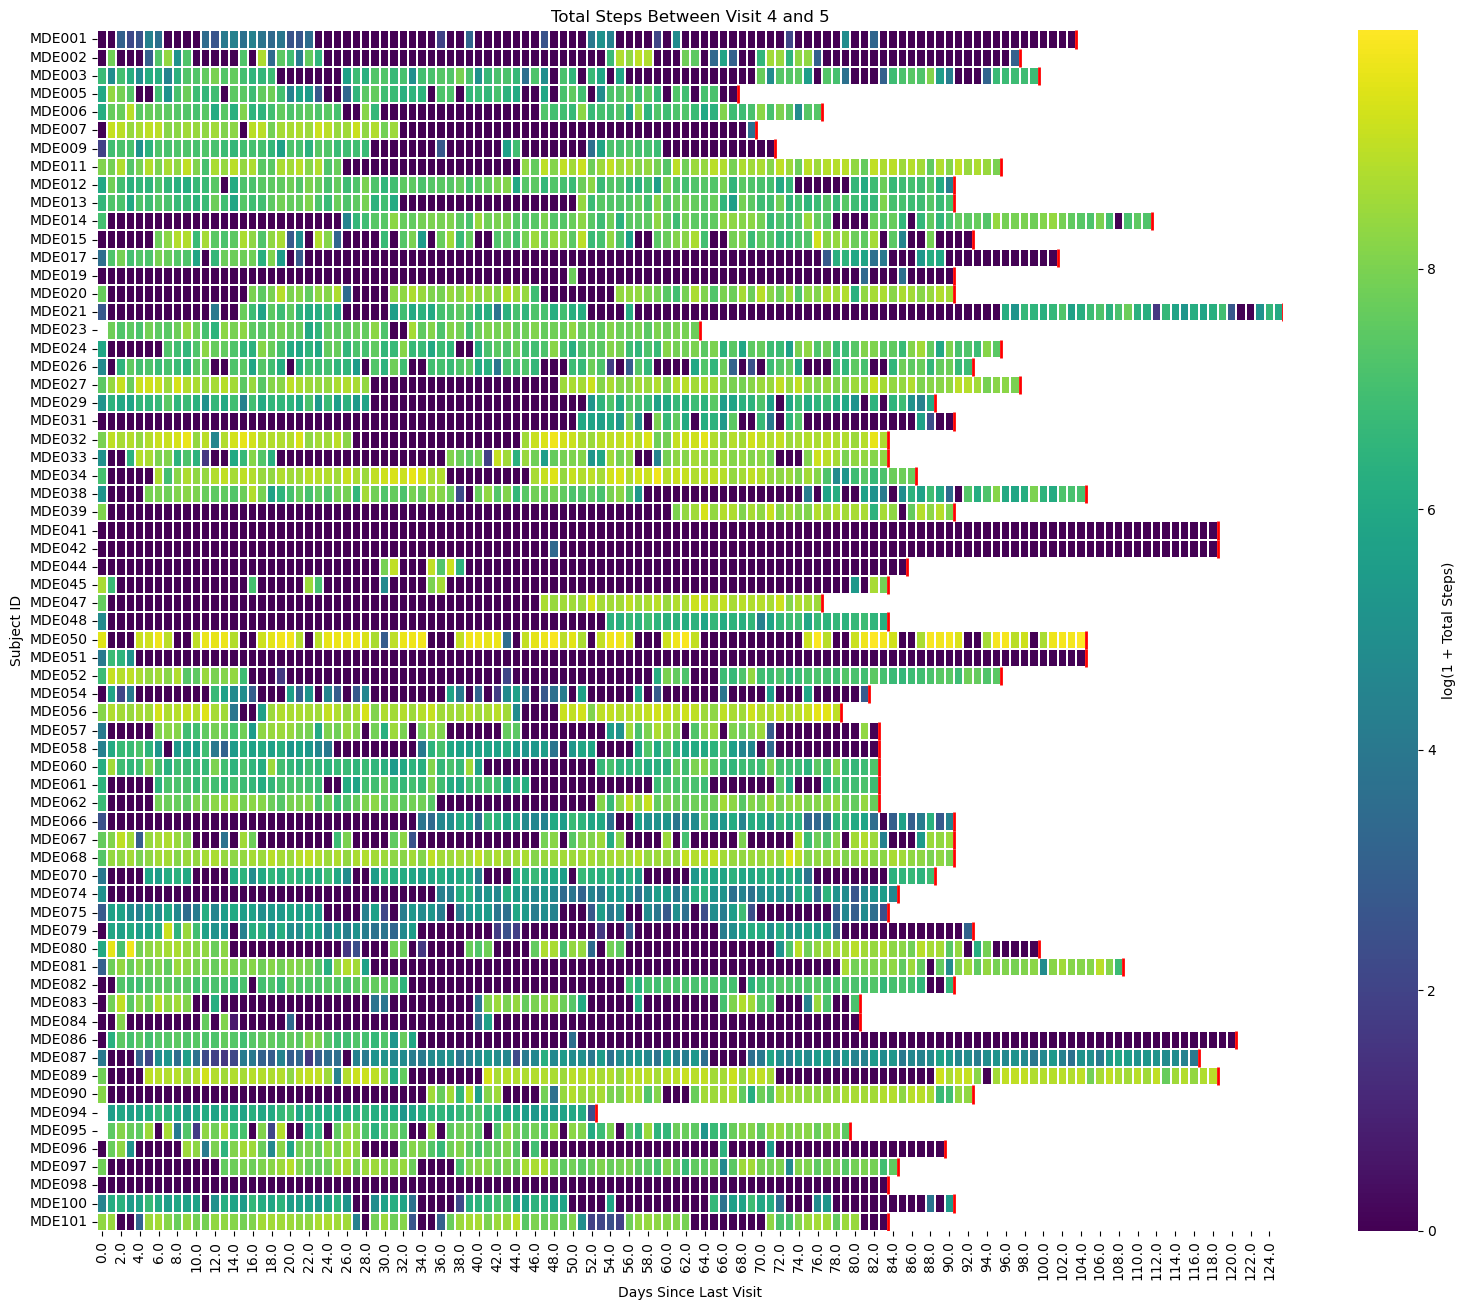

In [17]:
# Plot heatmap of total steps between visits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

visit_ids = sorted(df_visit['visit_id'].unique())
for i in range(len(visit_ids) - 1):
    v_start = visit_ids[i]
    v_end = visit_ids[i + 1]
    # Get visit n and n+1 dates for each subject
    visit_n = df_visit[df_visit['visit_id'] == v_start][['subject_id', 'date']].rename(columns={'date': 'start_date'})
    visit_np1 = df_visit[df_visit['visit_id'] == v_end][['subject_id', 'date']].rename(columns={'date': 'end_date'})
    visit_window = visit_n.merge(visit_np1, on='subject_id', how='inner')
    # Filter measurements for this interval
    mask = df_measurement['subject_id'].isin(visit_window['subject_id'])
    filtered = df_measurement[mask].merge(visit_window, on='subject_id', how='left')
    filtered = filtered[(filtered['date'] > filtered['start_date']) & (filtered['date'] <= filtered['end_date'])]
    heatmap_data = filtered.pivot_table(index='subject_id', columns='days_since_last_visit', values='total_steps', aggfunc='sum')
    log_heatmap_data = np.log1p(heatmap_data)
    # Plot
    plt.figure(figsize=(16, max(6, 0.2*log_heatmap_data.shape[0])))
    ax = sns.heatmap(
        log_heatmap_data,
        cmap='viridis',
        cbar_kws={'label': 'log(1 + Total Steps)'},
        linewidths=0.1
    )
    plt.title(f'Total Steps Between Visit {v_start} and {v_end}')
    plt.xlabel('Days Since Last Visit')
    plt.ylabel('Subject ID')
    # Mark the next visit date for each subject
    for j, subject in enumerate(log_heatmap_data.index):
        subject_days = log_heatmap_data.columns[~log_heatmap_data.loc[subject].isna()]
        if len(subject_days) > 0:
            last_day = subject_days.max()
            col_idx = list(log_heatmap_data.columns).index(last_day)
            ax.vlines(col_idx + 1, j, j + 1, color='red', linewidth=2)
    plt.tight_layout()
    plt.show()

In [ ]:
## TODO: Data quality check needed
subject_id = "MDE003"
df_visit.query(f"subject_id == '{subject_id}'")

,subject_id,visit_id,date,prev_visit_date
10,MDE003,1,2021-07-21,NaN
11,MDE003,2,2021-08-30,2021-07-21
12,MDE003,3,2021-09-22,2021-08-30
13,MDE003,4,2021-10-11,2021-09-22
14,MDE003,5,2022-01-19,2021-10-11


In [27]:
# select subject_id = "MDE003"
df_measurement.query(f"subject_id == '{subject_id}'").sort_values("date")

,subject_id,date,total_steps,total_distance,sedentary_minutes,calories_bmr,days_since_last_visit
368,MDE003,2021-07-26,0.0,0.00,574.0,507.0,5.0
369,MDE003,2021-07-27,0.0,0.00,1440.0,1498.0,6.0
370,MDE003,2021-07-28,0.0,0.00,1440.0,1498.0,7.0
371,MDE003,2021-07-29,0.0,0.00,1440.0,1498.0,8.0
372,MDE003,2021-07-30,0.0,0.00,1440.0,1498.0,9.0
373,MDE003,2021-07-31,2549.0,1.85,1440.0,1503.0,10.0
374,MDE003,2021-08-01,1092.0,0.79,1440.0,1503.0,11.0
375,MDE003,2021-08-02,865.0,0.63,1440.0,1503.0,12.0
376,MDE003,2021-08-03,1584.0,1.15,1440.0,1503.0,13.0
377,MDE003,2021-08-04,1431.0,1.04,1440.0,1503.0,14.0
